In [ ]:
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')
from sim import make_dataset

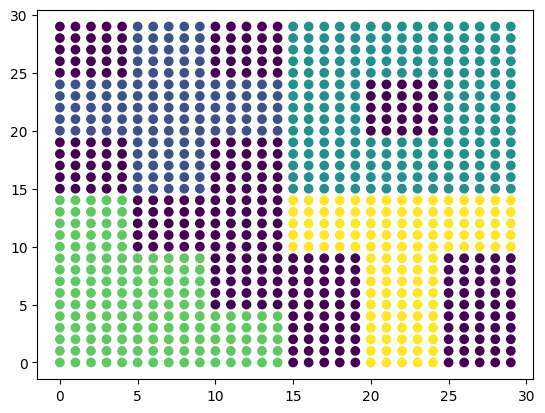

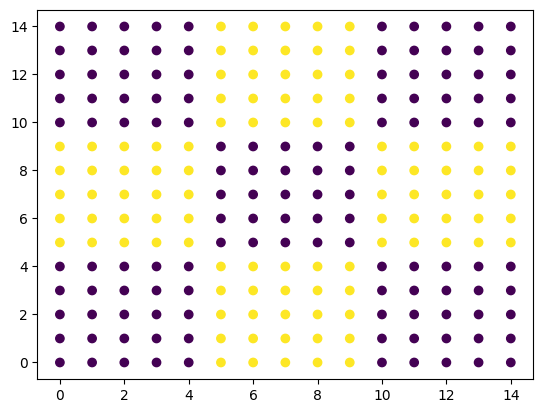

In [2]:
data, labels = make_dataset(('polygons', 'checkers'), 5)

idx = data[:, 0] == 0
plt.scatter(*data[idx, 1:3].T, c=labels[idx])
plt.show()

idx = data[:, 0] == 1
plt.scatter(*data[idx, 1:3].T, c=labels[idx])
plt.show()